In [1]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random

In [2]:
data_dir = Path('../../data')

## The goal of this project is to find B vectors(embedding) having trained Z matrix and observation data
### First let's try to find back the random set of B vectors

### Loading Y and Z and verifying we've got the right vectors
#### Y is a source data used for PLIER training. Y ≈ ZB

In [3]:
# transposing, so we have columns as features and rows as sample vectors
Y_df = pd.read_csv(data_dir / 'mat4.csv').transpose()
Y_df.shape

(4293, 55904)

In [4]:
Z_df = pd.read_csv(data_dir / 'plierResult/Z.csv')
Z_mat = Z_df.values
Z_df.shape

(5900, 258)

Z is a vertical matrix with columns matching the dimensionality of our embedding vector and number of rows matching the number of genes used

In [5]:
Z_genes = Z_df.index
print(f'{len(Z_genes)} genes in Z matrix')
z_in_y = Z_genes.isin(Y_df.columns).sum()
y_in_z = Y_df.columns.isin(Z_genes).sum()
print(f'{z_in_y * 100 / len(Z_genes)}% of them in matrix Y')
print(f'{y_in_z * 100 / len(Y_df.columns):0.2f}% of Y matrix genes in Z')

5900 genes in Z matrix
100.0% of them in matrix Y
10.55% of Y matrix genes in Z


#### Not all genes from original data(Y) present in Z matrix. Rest of the genes were droped by PLIER as less insignificant
Let's select only 5900 genes that present in matrix Z

In [6]:
Y_df = Y_df[Z_genes]
Y_df.shape

(4293, 5900)

#### Loading B matrix and sample some random vectors that we want to find back

In [7]:
# transposing, so we have columns as features and rows as sample vectors
B_df = pd.read_csv(data_dir / 'plierResult/B.csv').transpose()
B_df.shape

(4293, 258)

In [8]:
# number of vectors we'd like to find back
regr_subset_size = 100

# these are know embedding vectors, we will try to find them back and compare with originals
target_b_inds = random.choices(range(len(B_df)), k=regr_subset_size)
target_b_vectors = B_df.iloc[target_b_inds].values
target_b_vectors.shape

(100, 258)

In [9]:
# store samples associated with target embeddings
target_y_vectors = Y_df.iloc[target_b_inds].values
target_y_vectors.shape

(100, 5900)

### Before we run the regression let's make sure we have the right data and embeddings transformation works as we expect

In [10]:
target_ys = Y_df.iloc[target_b_inds]
target_ys.shape

(100, 5900)

In [11]:
target_ys.index.values[:5]

array(['SRX1541753', 'SRX2733610', 'SRX834970', 'SRX907064', 'SRX762935'],
      dtype=object)

In [12]:
B_df.index.values[:5]

array(['SRX890545', 'SRX1067711', 'SRX1067710', 'SRX762971', 'SRX762970'],
      dtype=object)

Make sure samples ids of selected samples are the same for selected embeddings. In other words, make sure the samples are in the same order in Y and B.

In [13]:
assert sum(target_ys.index != B_df.iloc[target_b_inds].index) == 0

Yes, it looks good.

In [14]:
Z_mat.shape, target_b_vectors.shape

((5900, 258), (100, 258))

#### Finally, let's make sure we can use Z matrix to decompress the embedding into the source vector

We need to transpose B matrics, so one column is a sample embedding vector

In [15]:
y_hat = np.matmul(Z_mat, target_b_vectors.transpose()).transpose()

In [16]:
y_hat.shape

(100, 5900)

#### y_hat is decompressed. It should be very close to Y vectors we stored before for the same samples

Using heatmap as a vert basic way to look for the similarity between set of vectors. All distances between items with the same index in both arrays should be very low comparing to distance between other pairs of vectors. This means, the diagonal of the matrix should be lower comparing to other cells.

`target_y_vectors` is a list of vectors we stored before hand. `y_hat` is a list of vectors we reconstructed using Z matrix and embeddings corresponding to samples in `target_y_vectors`.

<AxesSubplot:>

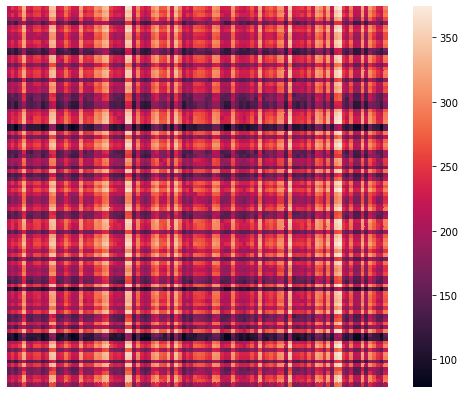

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(target_y_vectors, y_hat),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

### We've got a complete mess. Target values don't look like those we've got at all
#### Investigating the problem

(5900,)


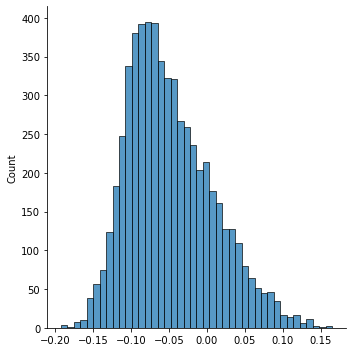

In [20]:
print(y_hat.mean(axis=0).shape)
sns.displot(y_hat.mean(axis=0))

(5900,)


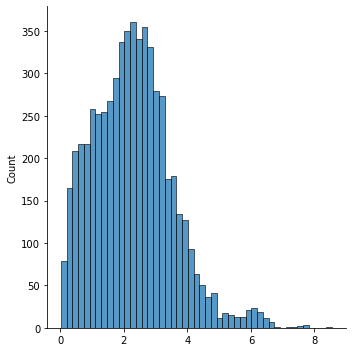

In [21]:
print(target_y_vectors.mean(axis=0).shape)
sns.displot(target_y_vectors.mean(axis=0))

### The distribution of data looks different. It looks like the source matrix was normalized when running the PLIER! It means the Y matrix that was actually used to compute B and Z matrices is different from the source one, that's why reconstructed Y vectors are different from source Y vectors
Let's see if normalizaing our source vectors can help

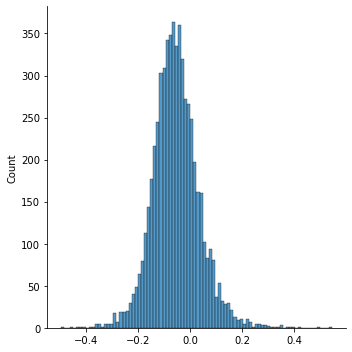

In [24]:
# computing normalization values on full dataset
per_gene_mean = Y_df.mean().values
target_y_norm = target_y_vectors - per_gene_mean

sns.displot(target_y_norm.mean(axis=0))

<AxesSubplot:>

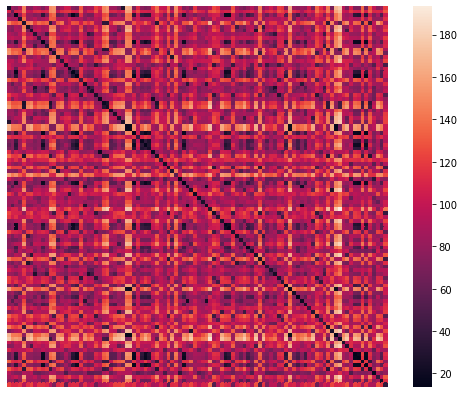

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

y2y_hat_dists = scipy.spatial.distance.cdist(target_y_norm, y_hat)
sns.heatmap(y2y_hat_dists,
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

### This looks much better!

In [38]:
per_gene_std = Y_df.std().values
target_y_norm = (target_y_vectors - per_gene_mean) / per_gene_std

<AxesSubplot:>

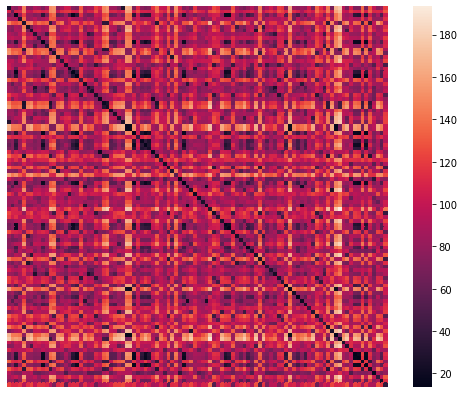

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

y2y_hat_dists = scipy.spatial.distance.cdist(target_y_norm, y_hat)
sns.heatmap(y2y_hat_dists,
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

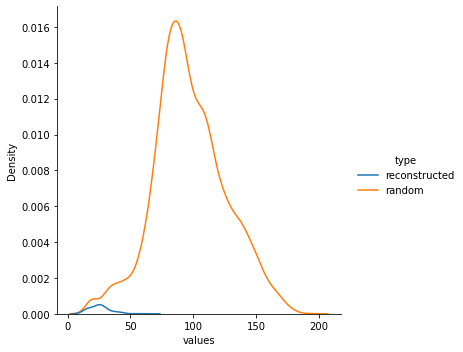

In [40]:
import pandas as pd

# distances between reconstructed Y vectors and associated target vectors
same_ind_dists = y2y_hat_dists.diagonal()

# get all values except the diagonal values
random_vectors_dists = y2y_hat_dists[~np.eye(y2y_hat_dists.shape[0], dtype=bool)]

dists_df = pd.DataFrame({
    'values': list(same_ind_dists) + list(random_vectors_dists),
    'type': ['reconstructed'] * len(same_ind_dists) + ['random'] * len(random_vectors_dists)
})

sns.displot(data=dists_df, x='values', hue='type', kind='kde')

We could also compute the P-value based on these distributions.

## Using regression to find the B that will produce vector close to target_y_norm

In [41]:
from numpy.linalg import inv

In [42]:
X = Z_mat

In [43]:
# linear least squares
# check this for more details: https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/
b = inv(X.T.dot(X)).dot(X.T).dot(target_y_norm.T)
b.shape

(258, 100)

### Looking at reconstructed vectors. How close are the values from actual b vectors?

<AxesSubplot:>

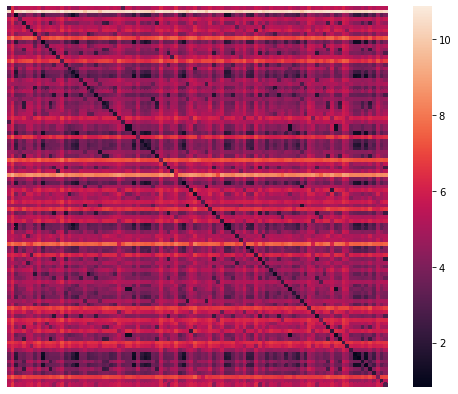

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(b.T, target_b_vectors),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

#### Let's try to compare source Y vales to values reconstructed using Z and reconstructed B

In [45]:
y_hat_hat = Z_mat.dot(b).transpose()
y_hat_hat.shape

(100, 5900)

<AxesSubplot:>

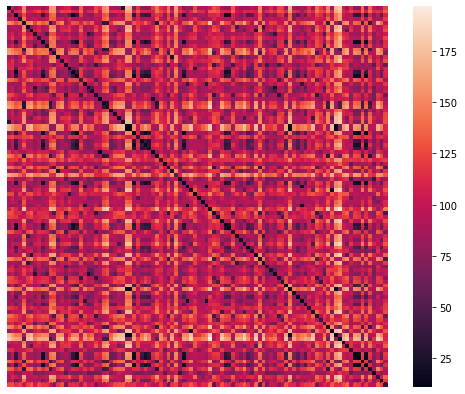

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

y2y_hat_hat_dists = scipy.spatial.distance.cdist(target_y_norm, y_hat_hat)
sns.heatmap(y2y_hat_hat_dists,
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

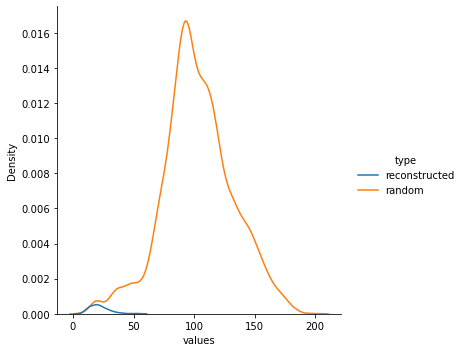

In [47]:
# distances between reconstructed Y vectors and associated target vectors
same_ind_dists = y2y_hat_hat_dists.diagonal()

# get all values except the diagonal values
random_vectors_dists = y2y_hat_hat_dists[~np.eye(y2y_hat_hat_dists.shape[0], dtype=bool)]

dists_df = pd.DataFrame({
    'values': list(same_ind_dists) + list(random_vectors_dists),
    'type': ['reconstructed'] * len(same_ind_dists) + ['random'] * len(random_vectors_dists)
})

sns.displot(data=dists_df, x='values', hue='type', kind='kde')

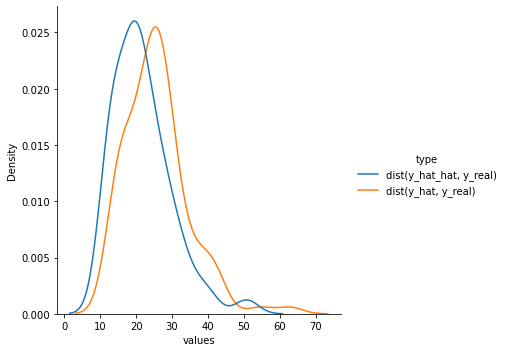

In [48]:
# distances between Y vectors reconstructed from infered B and associated target vectors
y2y_hat_hat_dists_diag = y2y_hat_hat_dists.diagonal()

# distances between reconstructed Y vectors and associated target vectors
y2y_hat_dists_diag = y2y_hat_dists.diagonal()

dists_df = pd.DataFrame({
    'values': list(y2y_hat_hat_dists_diag) + list(y2y_hat_dists_diag),
    'type': ['dist(y_hat_hat, y_real)'] * regr_subset_size + ['dist(y_hat, y_real)'] * regr_subset_size
})

sns.displot(data=dists_df, x='values', hue='type', kind='kde')

In [50]:
dists_df = pd.DataFrame({
    'y_real-y_hat': y2y_hat_dists_diag,
    'y_real-y_hat_hat': y2y_hat_hat_dists_diag
})

<AxesSubplot:xlabel='y_real-y_hat', ylabel='y_real-y_hat_hat'>

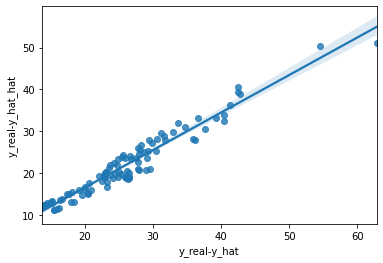

In [54]:
sns.regplot(data=dists_df, x='y_real-y_hat', y='y_real-y_hat_hat')

### Using Pearson correlation as a distance

In [69]:
def pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

In [70]:
y2y_hat_p_dists = pearson_dists(target_y_norm, y_hat)
y2y_hat_hat_p_dists = pearson_dists(target_y_norm, y_hat_hat)

<AxesSubplot:>

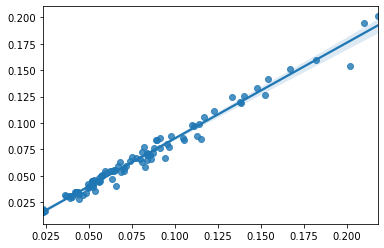

In [71]:
sns.regplot(x=y2y_hat_p_dists, y=y2y_hat_hat_p_dists)

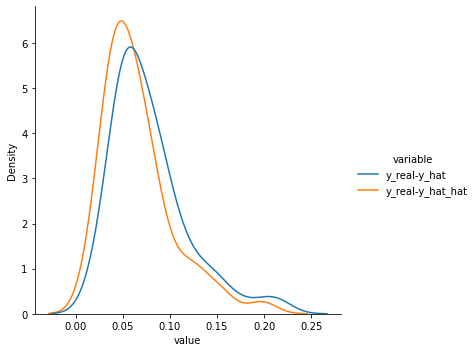

In [76]:
dists_df = pd.DataFrame({
    'y_real-y_hat': y2y_hat_p_dists,
    'y_real-y_hat_hat': y2y_hat_hat_p_dists
})

sns.displot(
    data=pd.melt(dists_df, value_vars=['y_real-y_hat', 'y_real-y_hat_hat']), 
    x='value', hue='variable', kind='kde')